# Image Reconstruction

In [1]:
import pyvista as pv
#pv.set_jupyter_backend('html')
pv.set_jupyter_backend('static')
#pv.OFF_SCREEN=True

In [2]:
import time

import matplotlib.pyplot as p
import numpy as np
import xarray as xr
from IPython.display import Image

import cedalion
import cedalion.dataclasses as cdc
import cedalion.datasets
import cedalion.geometry.registration
import cedalion.geometry.segmentation
import cedalion.imagereco.forward_model as fw
import cedalion.imagereco.tissue_properties
import cedalion.io
import cedalion.plots
from cedalion.imagereco.solver import pseudo_inverse_stacked

xr.set_options(display_expand_data=False);

## Load a finger-tapping dataset 

For this demo we load an example finger-tapping recording through `cedalion.datasets.get_fingertapping`. The file contains a single NIRS element with one block of raw amplitude data. 

In [3]:
rec = cedalion.datasets.get_fingertappingDOT()

The location of the probes is obtained from the snirf metadata (i.e. /nirs0/probe/)

Note that units ('m') are adopted and the coordinate system is named 'digitized'.

In [4]:
geo3d_meas = rec.geo3d
display(geo3d_meas)

Magnitude,[[-77.817871 15.680613999999998 23.172269999999997] [-61.906841 21.227732000000003 56.492802] [-85.37146 -16.079958 8.900885] ... [77.521 28.883 -39.113] [80.59 14.229 -38.278] [81.95 -0.678 -37.027]]
Units,millimeter


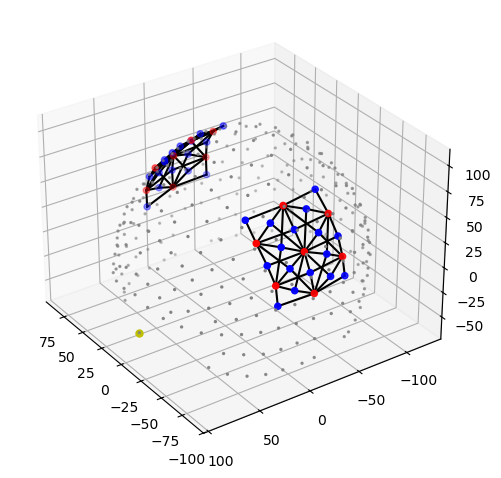

In [5]:
cedalion.plots.plot_montage3D(rec["amp"], geo3d_meas)

The measurement list is a `pandas.DataFrame` that describes which source detector pairs form channels.

In [6]:
meas_list = rec._measurement_lists["amp"]
display(meas_list.head(5))

,sourceIndex,detectorIndex,wavelengthIndex,wavelengthActual,wavelengthEmissionActual,dataType,dataUnit,dataTypeLabel,dataTypeIndex,sourcePower,detectorGain,moduleIndex,sourceModuleIndex,detectorModuleIndex,channel,source,detector,wavelength,chromo
0,1,1,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D1,S1,D1,760.0,None
1,1,2,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D2,S1,D2,760.0,None
2,1,4,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D4,S1,D4,760.0,None
3,1,5,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D5,S1,D5,760.0,None
4,1,6,1,None,None,1,None,raw-DC,1,None,None,None,None,None,S1D6,S1,D6,760.0,None


Event/stimulus information is also stored in a `pandas.DataFrame`. Here events are given more descriptive names:

In [7]:
rec.stim.cd.rename_events(
        {"1": "Rest", 
         "2": "FTapping/Left", 
         "3": "FTapping/Right",
         "4": "BallSqueezing/Left",
         "5": "BallSqueezing/Right"}
    )
display(rec.stim.groupby("trial_type")[["onset"]].count())

,onset
trial_type,
BallSqueezing/Left,17
BallSqueezing/Right,16
FTapping/Left,16
FTapping/Right,16
Rest,65


(for this demo select 20 seconds after a trial starts at t=117s and transform raw amplitudes to optical density)

Transform CW raw amplitudes to optical density

In [8]:
raw_amp = rec["amp"]
rec["od"] = -np.log( raw_amp/ raw_amp.mean("time"))
display(rec["od"])

Magnitude,[[[0.022629713866607847 0.023216836532708278 0.013684467620346493 ... -0.010620461702132364 -0.017602987397614237 -0.03652826755353624] [-0.023967015504601393 -0.023721591828952327 -0.035047284989283334 ... 0.01952854843775874 0.009757481781204926 -0.015230144300532406]] [[-0.012872986884990481 -0.011332124797665972 -0.016572408977445236 ... 0.011923329794529093 0.005278237141142663 -0.006110648587761814] [-0.02700224000406016 -0.024246108269988825 -0.03146924270509666 ... 0.02181988340299669 0.012033707485390443 -0.0041064160116489525]] [[0.0006156535996794966 0.0010662238510312694 -0.004407599676353052 ... 0.007022311734344929 0.004306301505785697 -0.009447093425633199] [-0.024426031897210095 -0.023403966743477868 -0.03068020929732877 ... 0.034761420177761404 0.027127675656147765 0.008446398309429448]] ... [[-0.0036518248509364633 -0.0059276181031083204 -0.012507170911435935 ... 0.017577039666719804 0.02317941680557893 0.03108860761777841] [-0.03896968330284641 -0.042762532955116936 -0.05342614179481423 ... 0.0327033138442992 0.03481989714579948 0.04241398226118306]] [[-0.007309677510355329 -0.01139195084670228 -0.017530814621337862 ... -0.005822449835728727 0.001530066181321768 0.009459282815759244] [-0.04139001975182615 -0.046120784069593516 -0.05675180784027597 ... 0.01075199997227985 0.009717211464164368 0.01837091753402615]] [[-0.001574636591885695 -0.004079125634634875 -0.011241225822598259 ... 0.005436176355749423 0.00856973714232694 0.013049917214507066] [-0.03572415797948889 -0.03951942096582957 -0.05224963138131106 ... 0.023428825169193434 0.022739748304107542 0.02761440347582048]]]
Units,dimensionless


## Calculate block averages in optical density

In [9]:
rec["od_freqfiltered"] = rec["od"].cd.freq_filter(fmin=0.02, fmax=0.5, butter_order=4)

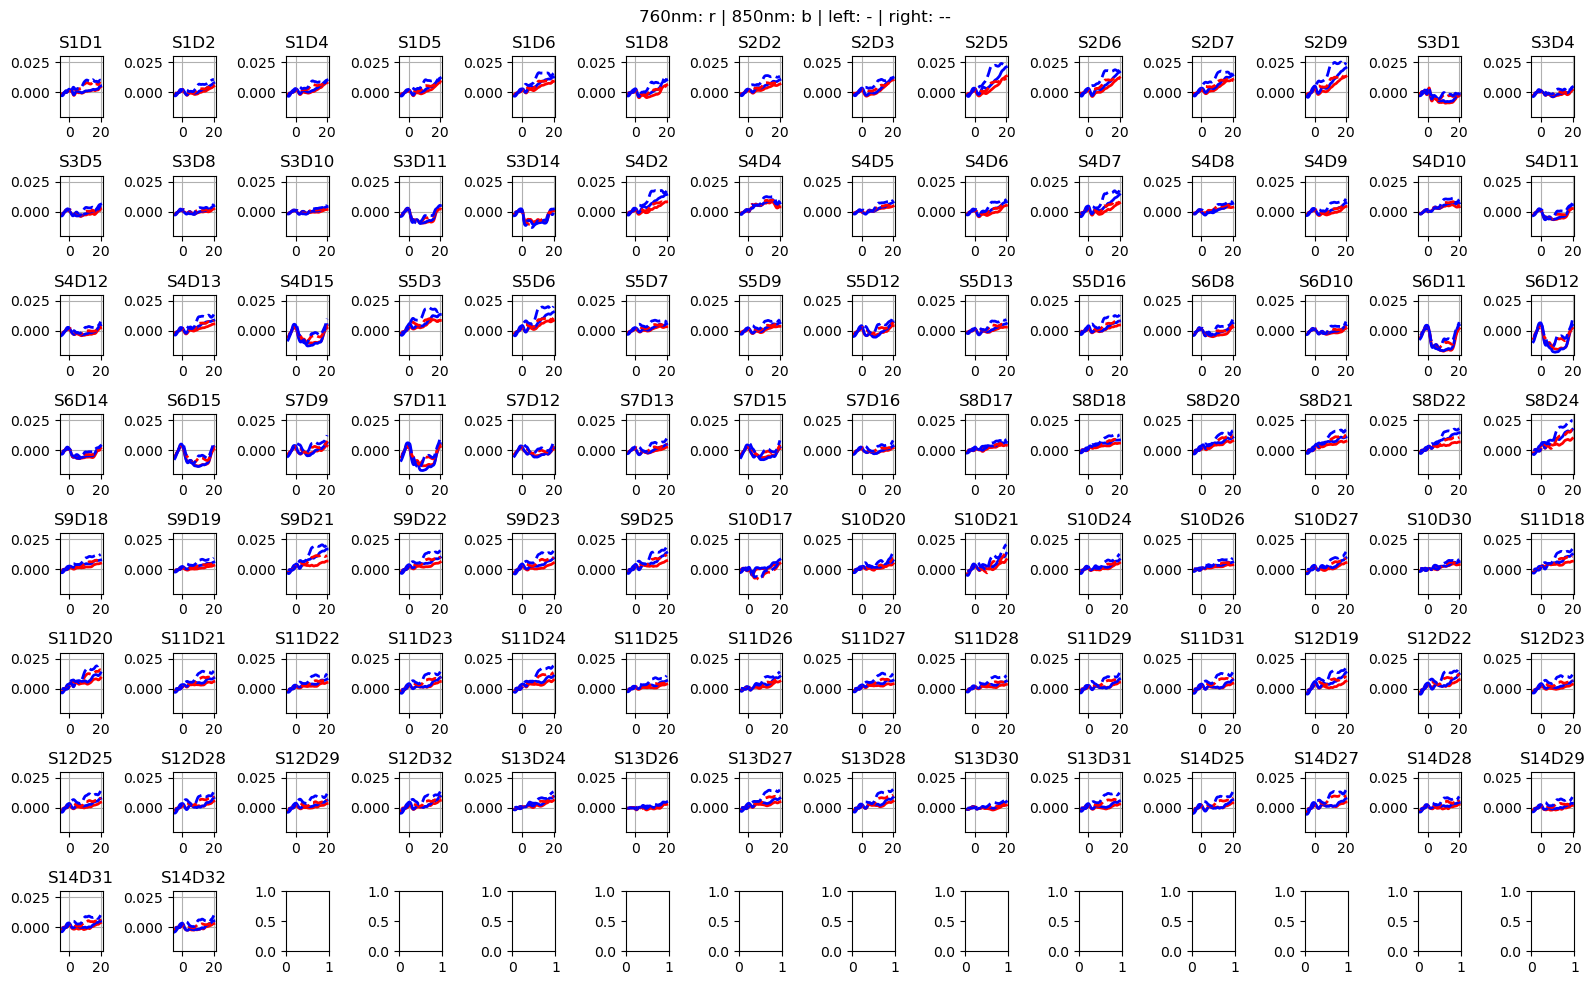

In [17]:
epochs = rec["od_freqfiltered"].cd.to_epochs(
        rec.stim, # stimulus dataframe
        ["FTapping/Left", "FTapping/Right"],  # select events
        before=5, # seconds before stimulus
        after=20  # seconds after stimulus
)

# calculate baseline
baseline = epochs.sel(reltime=(epochs.reltime < 0)).mean("reltime")
# subtract baseline
epochs_blcorrected = epochs - baseline

# group trials by trial_type. For each group individually average the epoch dimension
blockaverage = epochs_blcorrected.groupby("trial_type").mean("epoch")

# show results
f,ax = p.subplots(8,14, figsize=(16,10))
ax = ax.flatten()
for i_ch, ch in enumerate(blockaverage.channel):
    for ls, trial_type in zip(["-", "--"], blockaverage.trial_type):    
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(wavelength=760, trial_type=trial_type, channel=ch), "r", lw=2, ls=ls)
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(wavelength=850, trial_type=trial_type, channel=ch), "b", lw=2, ls=ls)
    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-.02, .03)
    

p.suptitle("760nm: r | 850nm: b | left: - | right: --")
p.tight_layout()



## Load segmented MRI scan

For this example use a segmentation of the Colin27 average brain.

In [18]:
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()

The segmentation masks are in individual niftii files. The dict `mask_files` maps mask filenames relative to `SEG_DATADIR` to short labels. These labels describe the tissue type of the mask. 

In principle the user is free to choose these labels. However, they are later used to lookup the tissue's optical properties. So they must be map to one of the tabulated tissue types (c.f. `cedalion.imagereco.tissue_properties.TISSUE_LABELS`).

The variable `landmarks_file` holds the path to a file containing landmark positions in scanner space (RAS). This file can be created with Slicer3D.

In [19]:
display(SEG_DATADIR)
display(mask_files)
display(landmarks_file)

'C:\\Users\\avonl\\AppData\\Local\\cedalion\\cedalion\\Cache\\colin27_segmentation.zip.unzip\\colin27_segmentation'

{'csf': 'mask_csf.nii',
 'gm': 'mask_gray.nii',
 'scalp': 'mask_skin.nii',
 'skull': 'mask_bone.nii',
 'wm': 'mask_white.nii'}

'landmarks.mrk.json'

## Coordinate systems

Up to now we have geometrical data from three different coordinate reference systems (CRS):

- The optode positions are in one space `CRS='digitized'` and the coordinates are in meter. In our example the origin is at the head center and y-axis pointing in the superior direction. Other digitization tools can use other units or coordinate systems.
- The segmentation masks are in voxel space (`CRS='ijk'`) in which the voxel edges are aligned with the coordinate axes. Each voxel has unit edge length, i.e. coordinates are dimensionless. 
  Axis-aligned grids are computationally efficient, which is why the photon simulation code (MCX) uses this coordinate system.
- The voxel space (`CRS='ijk'`) is related to scanner space (`CRS='ras'` or `CRS='aligned'`) in which coordinates have physical units and coordinate axes point to the (r)ight, (a)nterior and s(uperior) directions. The relation between both spaces is given through an affine transformation (e.g. `t_ijk2ras`). When loading the segmentation masks in Slicer3D this transformation is automatically applied. Hence, the picked landmark coordinates are exported in RAS space.

  The niftii file provides a string label for the scanner space. In this example the RAS space is called 'aligned' because the masks are aligned to another MRI scan.


To avoid confusion between these different coordinate systems, `cedalion` tries to be explicit about which CRS a given point cloud or surface is in.

## The TwoSurfaceHeadModel

The photon propagation considers the complete MRI scan, in which each voxel is attributed to one tissue type with its respective optical properties. However, the image reconstruction does not intend to reconstruct absorption changes in each voxel. The inverse problem is simplified, by considering only two surfaces (scalp and brain) and reconstruct only absorption changes in voxels close to these surfaces.

The class `cedalion.imagereco.forward_model.TwoSurfaceHeadModel` groups together the segmentation mask, landmark positions and affine transformations as well as the scalp and brain surfaces. The brain surface is calculated by grouping together white and gray matter masks. The scalp surface encloses the whole head.

In [20]:
head = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    landmarks_ras_file=landmarks_file
)

In [ ]:
head.segmentation_masks

In [ ]:
head.landmarks

In [ ]:
head.brain

In [ ]:
head.scalp

`TwoSurfaceHeadModel.from_segmentation` converts everything into voxel space (`CRS='ijk'`)

In [ ]:
head.crs

The transformation matrix to translate from voxel to scanner space:

In [ ]:
head.t_ijk2ras

Changing between coordinate systems:

In [21]:
head_ras = head.apply_transform(head.t_ijk2ras)
display(head_ras.crs)
display(head_ras.brain)

'aligned'

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(89995, 3), faces.shape=(180000, 3))>, crs='aligned', units=<Unit('millimeter')>)

## Optode Registration
The optode coordinates from the recording must be aligned with the scalp surface. Currently, `cedaĺion` offers a simple registration method, which finds an affine transformation (scaling, rotating, translating) that matches the landmark positions of the head model and their digitized counter parts. Afterwards, optodes are snapped to the nearest vertex on the scalp.

In [22]:
geo3d_snapped_ijk = head.align_and_snap_to_scalp(geo3d_meas)
display(geo3d_snapped_ijk)

Magnitude,[[55.93086023841647 130.10776338208507 109.10767178999693] [68.86440740272819 131.79154635803576 144.29328968074566] [51.900053673843914 108.78751562999123 90.75889925838965] ... [197.1072234944255 153.79841707978954 59.033354451391176] [198.30181387296466 143.9921710380966 57.227878030400355] [199.41145054050628 128.11339336918684 55.22920396349021]]
Units,dimensionless


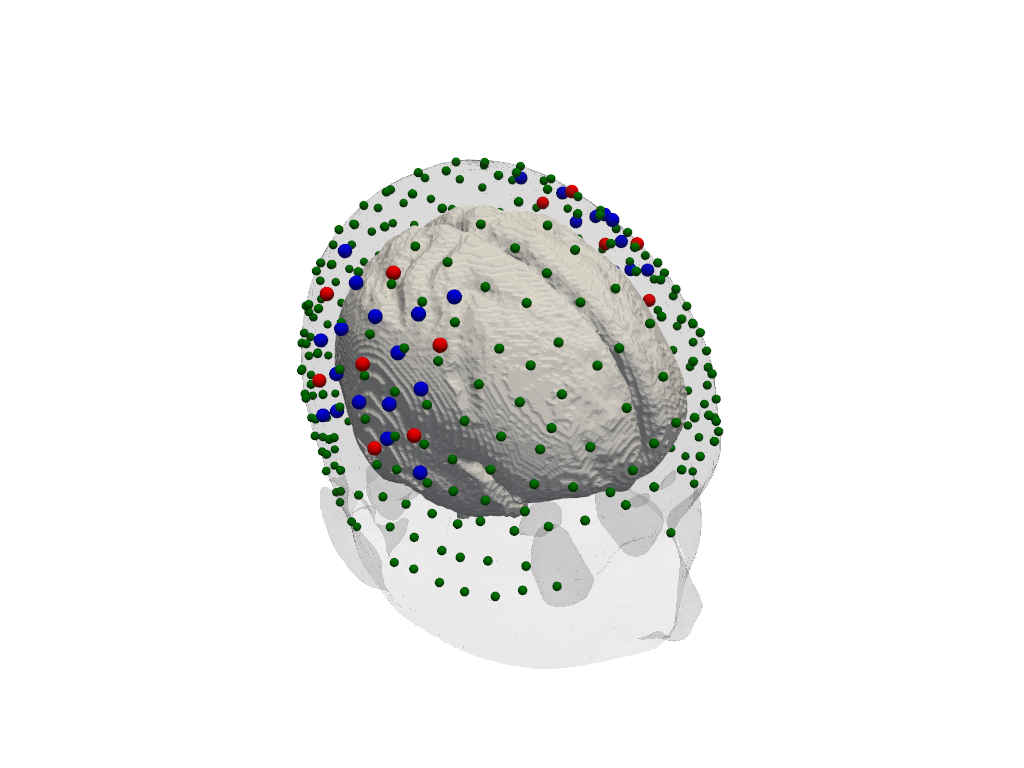

In [23]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)
plt.show()

## Simulate light propagation in tissue

`cedalion.imagereco.forward_model.ForwardModel` is a wrapper around pmcx. Using the data in the head model it prepares the inputs for either pmcx or NIRFASTer and offers functionality to calculate the sensitivty matrix.

In [24]:
fwm = cedalion.imagereco.forward_model.ForwardModel(head, geo3d_snapped_ijk, meas_list)

### Run the simulation

The `compute_fluence_mcx` and `compute_fluence_nirfaster` methods simulate a light source at each optode position and calculate the fluence in each voxel. By setting `RUN_PACKAGE`, you can choose between the pmcx or NIRFASTer package to perform this simulation.

In [25]:
USE_CACHED = False
RUN_PACKAGE = 'NIRFASTer' # or 'MCX'

if USE_CACHED:
    fluence_all, fluence_at_optodes = cedalion.datasets.get_imagereco_example_fluence()
else:
    if RUN_PACKAGE == 'MCX':
        fluence_all, fluence_at_optodes = fwm.compute_fluence_mcx()
    elif RUN_PACKAGE == 'NIRFASTer':
        fluence_all, fluence_at_optodes = fwm.compute_fluence_nirfaster()



import gzip
import pickle

# save computed fluence data (xarrays) to disk to avoid having to re-run each time
file = gzip.GzipFile('C:/Users/avonl/OneDrive/Desktop/'+'image_reconstruction_fluence_DOT.gz', 'wb')
file.write(pickle.dumps([fluence_all, fluence_at_optodes]))
file.close()

Running CGAL mesher
Meshing...

Running local optimization...

 Removed 4 unused nodes from mesh!

Converting to NIRFAST format
Calculating the MASS matrix
Solving the system


The photon simulation yields the fluence in each voxel for each wavelength.

In [ ]:
fluence_all

Also, for a each combination of two optodes, the fluence in the voxels at the optode positions is calculated.

In [ ]:
fluence_at_optodes

## Plot fluence

To illustrate the tissue probed by light travelling from a source to the detector two fluence profiles need to be multiplied. 

In [ ]:
time.sleep(1)

plt = pv.Plotter()

f = fluence_all.loc["S1", 760].values * fluence_all.loc["D1",760].values
f[f<=0] = f[f>0].min()
f = np.log10(f)
vf = pv.wrap(f)

plt.add_volume(
    vf,
    log_scale=False, 
    cmap='plasma_r',
    clim=(-10,0),
)
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)

cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [-300,30, 150]
plt.camera.focal_point = cog 
plt.camera.up = [0,0,1] 

plt.show()

### Calculate the sensitivity matrices

The sensitivity matrix describes the effect of an absorption change at a given surface vertex in the OD recording in a given channel and at given wavelength. The coordinate `is_brain` holds a mask to distinguish brain and scalp voxels.

In [ ]:
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)
Adot

The sensitivity `Adot` has shape (nchannel, nvertex, nwavelenghts). To solve the inverse problem we need a matrix that relates OD in channel space to absorption in image space. Hence, the sensitivity must include the extinction coefficients to translate between OD and concentrations. Furthermore, channels at different wavelengths must be  stacked as well vertice and chromophores into new dimensions (flat_channel, flat_vertex):

$$ \left( \begin{matrix} OD_{c_1, \lambda_1} \\ \vdots \\ OD_{c_N,\lambda_1} \\ OD_{c_1,\lambda_2} \\ \vdots \\ OD_{c_N,\lambda_2} \end{matrix}\right) = A \cdot
\left( \begin{matrix} \Delta c_{v_1, HbO} \\ \vdots \\ \Delta c_{v_N, HbO} \\ \Delta c_{v_1, HbR} \\ \vdots \\ \Delta c_{v_N, HbR} \end{matrix}\right) $$

In [ ]:
Adot_stacked = fwm.compute_stacked_sensitivity(Adot)
Adot_stacked

### Invert the sensitivity matrix

In [ ]:
B = pseudo_inverse_stacked(Adot_stacked)
nvertices = B.shape[0]//2
B = B.assign_coords({"chromo" : ("flat_vertex", ["HbO"]*nvertices  + ["HbR"]* nvertices)})
B = B.set_xindex("chromo")
B

### Calculate concentration changes

- the optical density has shape (nchannel, nwavelength, time) -> stack channel and wavelength dimension into new flat_channel dimension

In [ ]:
blockaverage

In [ ]:
od_stacked = blockaverage.stack({"flat_channel" : ["wavelength", "channel"]})
display(od_stacked)

multiply with the inverted sensitivity matrix. contracts over flat_channel and the flat_vertex dimension remains

In [ ]:
dC = B @ od_stacked
dC

## Plot concentration changes

Using functionality from pyvista and VTK plot the concentration changes on the brain surface

In [ ]:
b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)

In [ ]:
# plot brain surface

for trial_type, gif_fname in [("Tapping/Left", "hbo_left.gif"), ("Tapping/Right", "hbo_right.gif")]:

    hbo = dC.sel(chromo="HbO", trial_type=trial_type).pint.dequantify() / 1e-6 # FIXME unit handling
    hbo_brain = hbo[(Adot.is_brain == True).values,:]

    ntimes = hbo.sizes["reltime"]

    b = cdc.VTKSurface.from_trimeshsurface(head.brain)
    b = pv.wrap(b.mesh)
    b["reco_hbo"] = (hbo_brain[:,0] - hbo_brain[:,0])

    plt = pv.Plotter()

    plt.add_mesh(
        b,
        scalars="reco_hbo",
        cmap='seismic', # 'gist_earth_r', 
        clim=(-0.3,0.3),
        scalar_bar_args = {"title" : "HbO / µM"}
    )

    cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)


    tl = lambda tt : f"{trial_type} HbO rel. time: {tt:.3f} s"
    time_label = plt.add_text(tl(0))

    cog = head.brain.vertices.mean("label").values
    plt.camera.position = cog + [0,0,400]
    plt.camera.focal_point = cog 
    plt.camera.up = [0,1,0] 
    plt.reset_camera()

    plt.open_gif(gif_fname)

    for i in range(0,ntimes,3):
        b["reco_hbo"] = (hbo_brain[:,i] - hbo_brain[:,0])
        time_label.set_text("upper_left", tl(hbo_brain.reltime[i]))

        plt.write_frame()

    plt.close()

In [ ]:
display(Image(data=open("hbo_left.gif",'rb').read(), format='png'))
display(Image(data=open("hbo_right.gif",'rb').read(), format='png'))